# Neural networks - Optical Character Recognition (OCR)

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import numpy as np

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Import Theano 

In [2]:
env MKL_THREADING_LAYER=GNU

env: MKL_THREADING_LAYER=GNU


In [3]:
import theano
import theano.tensor as T

### Using MNIST database

In [4]:
import os

datasets_dir = 'data/'

def one_hot(x,n):
    if type(x) == list:
        x = np.array(x)
    x = x.flatten()
    o_h = np.zeros((len(x),n))
    o_h[np.arange(len(x)),x] = 1
    return o_h

def mnist(ntrain=60000,ntest=10000,onehot=True):
    data_dir = os.path.join(datasets_dir,'mnist/')
    fd = open(os.path.join(data_dir,'train-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join(data_dir,'train-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join(data_dir,'t10k-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join(data_dir,'t10k-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))

    trX = trX/255.
    teX = teX/255.

    trX = trX[:ntrain]
    trY = trY[:ntrain]

    teX = teX[:ntest]
    teY = teY[:ntest]

    if onehot:
        trY = one_hot(trY, 10)
        teY = one_hot(teY, 10)
    else:
        trY = np.asarray(trY)
        teY = np.asarray(teY)

    return trX,teX,trY,teY

trX, teX, trY, teY = mnist()

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


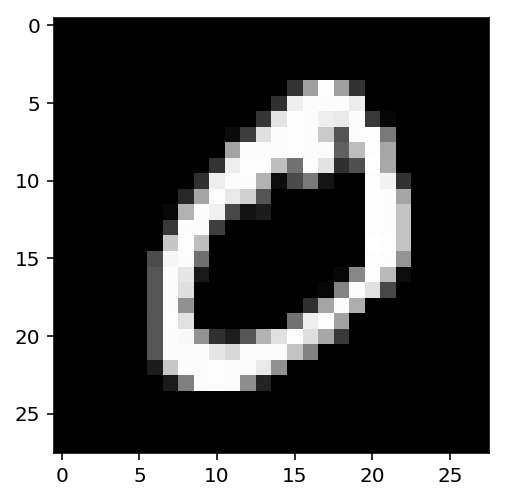

In [5]:
print(trY[1,:])
imshow(trX[1,:].reshape(28, 28), cmap = mpl.cm.gray)
show()

### Problem's analysis

Before implementing a neural network which can classify the images of dataset, it is necessary to analyse the shape of the input and output layers. The input layer is definied by the image's size, in this case, each image has 784 pixels, so the input layer's size will be 784. On the other hand, the output layer is definied by the characters to identify, in this case, the characters to identify are 10 (each one is one number from 0 to 9), so the output layer's size will be 10.

### First solution. One layer: 10 neurons, with 784 inputs each one. 

In [6]:
# Let's define functions for init the weights the random way:
def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

In [7]:
# Load dataset
trX, teX, trY, teY = mnist()

# Create the symbolic variables
X = T.fmatrix()
Y = T.fmatrix()
learning_rate = 0.1

# Initialize the weights
w = init_weights((784, 10)) # 10 neurons with 784 inputs

# Create the neurons
py_x = T.nnet.sigmoid(T.dot(X, w)) # Let's use the sigmoid neurons

# Create the output of neuralnet -> for prediction
# The output of neuralnet is the maximum value of the all neurons
y_pred = T.argmax(py_x, axis = 1)

# Create the effort function
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
gradient = T.grad(cost, w)

# Create the update function
update = [[w, w - gradient * learning_rate]]

# Create the traning function
train = theano.function(inputs = [X, Y],
                        outputs = cost,
                        updates = update,
                        allow_input_downcast = True)    # Make the data types conversion of 
                                                        # input data so that it will be adapted 
                                                        # to data types needed in the model

# Create the prediction function
predict = theano.function(inputs = [X],
                          outputs = y_pred,
                          allow_input_downcast = True)


In [8]:
num_iter = 25

# Training the model
for i in range(num_iter) :
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)) :
        cost = train(trX[start:end], trY[start:end])
    
    # Make the prediction
    pred = predict(teX)
    # Print the result
    print(i, np.mean(np.argmax(teY, axis = 1) == pred), cost)

0 0.721 0.0027029250705039904
1 0.7027 0.0012359935650084043
2 0.6929 0.0007827126020154541
3 0.6842 0.0005661670688884367
4 0.6782 0.0004404375966753246
5 0.6749 0.0003587461438120202
6 0.6713 0.00030161591541922066
7 0.6677 0.0002595307049547664
8 0.6649 0.00022730458286666656
9 0.6627 0.00020187703911309947
10 0.6611 0.00018132851666172823
11 0.6599 0.0001643957286224651
12 0.6585 0.00015021421087009279
13 0.6565 0.0001381729949705559
14 0.6559 0.00012782837096527995
15 0.6552 0.00011885053112700169
16 0.6544 0.00011098936515787504
17 0.654 0.00010405185281010549
18 0.6525 9.788671947520187e-05
19 0.652 9.237377559188429e-05
20 0.6514 8.741635558006916e-05
21 0.6504 8.293585544184047e-05
22 0.6494 7.886772073380761e-05
23 0.6485 7.515845551924303e-05
24 0.648 7.176336209440906e-05


With 25 iterations, the model has got a precision of 64.33%.

One way to improve this model is modify the neuron's type. In the last example, we used the `sigmoid` neuron. Now, we are going to use the `softmax` neuron. The implementation with this neuron is the following:

In [9]:
# Load dataset
trX, teX, trY, teY = mnist()

# Create the symbolic variables
X = T.fmatrix()
Y = T.fmatrix()
learning_rate = 0.1

# Initialize the weights
w = init_weights((784, 10)) # 10 neurons with 784 inputs

# Create the neurons
py_x = T.nnet.softmax(T.dot(X, w)) # Let's use the softmax neurons

# Create the output of neuralnet -> for prediction
# The output of neuralnet is the maximum value of the all neurons
y_pred = T.argmax(py_x, axis = 1)

# Create the effort function
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
gradient = T.grad(cost, w)

# Create the update function
update = [[w, w - gradient * learning_rate]]

# Create the traning function
train = theano.function(inputs = [X, Y],
                        outputs = cost,
                        updates = update,
                        allow_input_downcast = True)    # Make the data types conversion of 
                                                        # input data so that it will be adapted 
                                                        # to data types needed in the model

# Create the prediction function
predict = theano.function(inputs = [X],
                          outputs = y_pred,
                          allow_input_downcast = True)


In [10]:
num_iter = 25

# Training the model
for i in range(num_iter) :
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)) :
        cost = train(trX[start:end], trY[start:end])
    
    # Make the prediction
    pred = predict(teX)
    # Print the result
    print(i, np.mean(np.argmax(teY, axis = 1) == pred), cost)

0 0.8976 0.1410743366750079
1 0.9072 0.11161650977249434
2 0.911 0.09968903727711292
3 0.9131 0.09282863142173241
4 0.9152 0.08825177029847385
5 0.916 0.08493602419833998
6 0.9176 0.08240406134611025
7 0.9185 0.08039836474664207
8 0.9191 0.07876580948445258
9 0.9196 0.07740875931823077
10 0.9196 0.07626160793535955
11 0.9198 0.07527843514866621
12 0.9199 0.07442603004817548
13 0.9202 0.07367971764752164
14 0.9202 0.07302074549995513
15 0.92 0.0724345843052235
16 0.9208 0.07190978738408238
17 0.9213 0.07143720432738752
18 0.9216 0.07100942602801297
19 0.9219 0.07062038488929062
20 0.9219 0.0702650615140738
21 0.9221 0.06993926595820882
22 0.9221 0.06963947215796719
23 0.922 0.0693626909077854
24 0.922 0.06910637121026347


We can observe that the results are better with the `softmax` neuron. Now, the model has got a precision of 92.19%.

### Second solution. Two layers: 625 neurons with 784 inputs each one, and 10 neurons with 625 inputs each one

In [11]:
# Let's define functions for init the weights the random way:
def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

In [12]:
# Load dataset
trX, teX, trY, teY = mnist()

# Create the symbolic variables
X = T.fmatrix()
Y = T.fmatrix()
learning_rate = 0.1

# Initialize the weights
w_h = init_weights((784, 625)) # 625 neurons with 784 inputs (hide layer) 
w_o = init_weights((625, 10))  # 10 neurons with 625 inputs  (output layer)

# Create the neurons
h = T.nnet.sigmoid(T.dot(X, w_h))    # For the hide layer, let's use the sigmoid
py_x = T.nnet.softmax(T.dot(h, w_o)) # Let's use the softmax neurons with the result of the hide layer

# Create the output of neuralnet -> for prediction
# The output of neuralnet is the maximum value of the all neurons
y_pred = T.argmax(py_x, axis = 1)

# Create the effort function
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
dw_h = T.grad(cost, w_h)
dw_o = T.grad(cost, w_o)

# Create the update function
updates = [[w_h, w_h - dw_h * learning_rate],
           [w_o, w_o - dw_o * learning_rate]]

# Create the traning function
train = theano.function(inputs = [X, Y],
                        outputs = cost,
                        updates = updates,
                        allow_input_downcast = True)    # Make the data types conversion of 
                                                        # input data so that it will be adapted 
                                                        # to data types needed in the model

# Create the prediction function
predict = theano.function(inputs = [X],
                          outputs = y_pred,
                          allow_input_downcast = True)


In [13]:
num_iter = 25

# Training the model
for i in range(num_iter) :
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)) :
        cost = train(trX[start:end], trY[start:end])
    
    # Make the prediction
    pred = predict(teX)
    # Print the result
    print(i, np.mean(np.argmax(teY, axis = 1) == pred), cost)

0 0.823 0.3734138127327109
1 0.8771 0.1527132943075869
2 0.8907 0.11456293864760102
3 0.8977 0.09880993861258901
4 0.9041 0.08944247557613755
5 0.9066 0.08281563473800227
6 0.9091 0.07771112933084755
7 0.9116 0.07361295555864907
8 0.9131 0.0702472972687059
9 0.9142 0.06743981992373496
10 0.915 0.06506632191559396
11 0.9169 0.06303284264473215
12 0.9179 0.06126611477910101
13 0.9191 0.059708194405558516
14 0.9205 0.058313027169474216
15 0.9222 0.05704404029054002
16 0.9226 0.05587235159832256
17 0.9242 0.054775393138720846
18 0.9249 0.05373583559280131
19 0.9264 0.05274072782382834
20 0.9284 0.05178076132947119
21 0.9293 0.05084955845688987
22 0.9306 0.04994289401470391
23 0.9323 0.049057830308201954
24 0.9337 0.04819189382381959


The precision got is the 93.4%. It is better than the last, although not much better because the precision already was high. As we increase the number of neurons and layers in a neuralnet is easy that the model will be unstable and overfitting can appear. This problem can be fixed using regularization techniques like `dropout`.

### Regularization techniques: Dropout 

This technique consists in turn off a percentage of neurons randomly during the training, like this, the contribution of these neurons in the model's training will not be considered and its weights will not be updates through backpropagation.

The implementation of this technique is the following:

In [14]:
from theano.sandbox.rng_mrg import MRG_RandomStreams

srng = MRG_RandomStreams() # Random values generator

# Dropout function's definition
def dropout(X, p):
    if p > 0:
        X *= srng.binomial(X.shape, p = 1 - p, dtype = theano.config.floatX)
        X /= 1 - p
    return X

# Model's creation.
#  X: input
#  w_h: hide layer's weights
#  w_o: output layer's weights
#  p_drop: probability of the neuron's turn off
def model(X, w_h, w_o, p_drop):
    X = dropout(X, p_drop)
    h = T.nnet.sigmoid(T.dot(X, w_h))
    
    h = dropout(h, p_drop)
    py_x = T.nnet.softmax(T.dot(h, w_o))

    return h, py_x

In [15]:
# Let's define functions for init the weights the random way:
def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

In [16]:
# Load dataset
trX, teX, trY, teY = mnist()

# Create the symbolic variables
X = T.fmatrix()
Y = T.fmatrix()
learning_rate = 0.1

# Initialize the weights
w_h = init_weights((784, 625)) # 625 neurons with 784 inputs (hide layer) 
w_o = init_weights((625, 10))  # 10 neurons with 625 inputs  (output layer)

# Create the training model with the 0.05 probability of the neurons turn off
h, py_x = model(X, w_h, w_o, 0.05)

# Create the effort function
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
dw_h = T.grad(cost, w_h)
dw_o = T.grad(cost, w_o)

# Create the update function
updates = [[w_h, w_h - dw_h * learning_rate],
           [w_o, w_o - dw_o * learning_rate]]

# Create the traning function
train = theano.function(inputs = [X, Y],
                        outputs = cost,
                        updates = updates,
                        allow_input_downcast = True)    # Make the data types conversion of 
                                                        # input data so that it will be adapted 
                                                        # to data types needed in the model

# Create the prediction model with the 0 probability of the neurons turn off
h_pred, py_pred = model(X, w_h, w_o, 0.0)
y_pred = T.argmax(py_pred, axis = 1)


# Create the prediction function
predict = theano.function(inputs = [X],
                          outputs = y_pred,
                          allow_input_downcast = True)

In [17]:
num_iter = 25

# Training the model
for i in range(num_iter) :
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)) :
        cost = train(trX[start:end], trY[start:end])
    
    # Make the prediction
    pred = predict(teX)
    # Print the result
    print(i, np.mean(np.argmax(teY, axis = 1) == pred), cost)

0 0.8187 0.3899279482807628
1 0.875 0.1710710303370585
2 0.8911 0.11364033990474715
3 0.8999 0.10564864778826542
4 0.9038 0.08954041223557303
5 0.9068 0.10605462035689366
6 0.9111 0.07906449620753736
7 0.9115 0.08267554004644682
8 0.9134 0.08692265700817278
9 0.9152 0.07876798194340817
10 0.9161 0.07938227970168125
11 0.9189 0.07529682797007944
12 0.919 0.08166355504407538
13 0.9221 0.06494165123617782
14 0.9232 0.060956696709127074
15 0.9243 0.06693294873547236
16 0.9251 0.07654063350524679
17 0.9265 0.07322145499318919
18 0.9283 0.07225238765282022
19 0.929 0.06423808436900896
20 0.9309 0.06412209271163288
21 0.9326 0.057904877354609224
22 0.9342 0.0569937612054843
23 0.9348 0.058714992857742926
24 0.9359 0.0499382670773902


In this case, the result is slightly greater than the last one.